In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import matplotlib.colors as mcolors

os.environ["OMP_NUM_THREADS"] = "5"

In [2]:
m = folium.Map([33.447046773463654, -112.08091337731709], zoom_start=5)

In [3]:
df = pd.read_csv('./../../CSVs/RAW/Battery and e-waste collection centers USA.csv')
df[['lon', 'lat']] = df['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df

,WKT,name,lon,lat
0,POINT (-118.3514773 34.0412734),"A1 Electronic Recycling,",-118.351477,34.041273
1,POINT (-118.42281 34.204152),"eWaste U.S. Electronics Recycling,",-118.422810,34.204152
2,POINT (-118.6000354 34.2135694),"CAL E-WASTE RECYCLE LLC,",-118.600035,34.213569
3,POINT (-118.4856892 34.2018167),"E -Waste LA (Data Destruction Company),",-118.485689,34.201817
4,POINT (-118.4168123 34.2606906),"pasadena tech recycle inc,",-118.416812,34.260691
...,...,...,...,...
59,POINT (-115.129013 35.987648),"PedalPoint evTerra Recycling,",-115.129013,35.987648
60,POINT (-115.1854335 36.078715),"BB Recycling,",-115.185434,36.078715
61,POINT (-115.0950232 36.2437766),"Nevada Recycling,",-115.095023,36.243777
62,POINT (-115.193616 36.0451545),"Advanced Technology Recycling (ATR),",-115.193616,36.045155


In [4]:
rad_lat = np.radians(df['lat'])
rad_lon = np.radians(df['lon'])

df['x'] = np.cos(rad_lat) * np.cos(rad_lon)
df['y'] = np.cos(rad_lat) * np.sin(rad_lon)
df['z'] = np.sin(rad_lat)

In [5]:
X = df[['x', 'y', 'z']]

In [6]:
k_values = range(2, 60)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

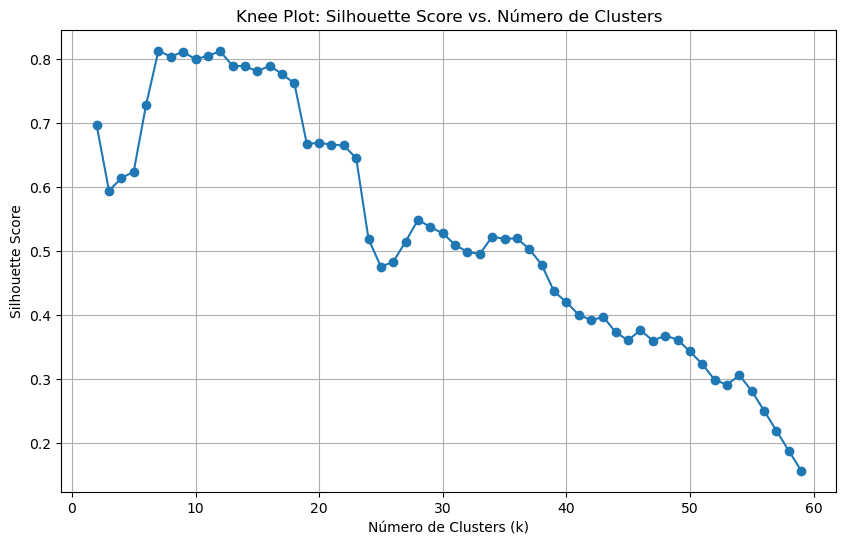

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Knee Plot: Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()

In [8]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.6137


In [9]:
df['cluster'] = cluster_labels
df

,WKT,name,lon,lat,x,y,z,cluster
0,POINT (-118.3514773 34.0412734),"A1 Electronic Recycling,",-118.351477,34.041273,-0.393501,-0.729241,0.559790,1
1,POINT (-118.42281 34.204152),"eWaste U.S. Electronics Recycling,",-118.422810,34.204152,-0.393650,-0.727348,0.562143,1
2,POINT (-118.6000354 34.2135694),"CAL E-WASTE RECYCLE LLC,",-118.600035,34.213569,-0.395853,-0.726046,0.562279,1
3,POINT (-118.4856892 34.2018167),"E -Waste LA (Data Destruction Company),",-118.485689,34.201817,-0.394459,-0.726935,0.562110,1
4,POINT (-118.4168123 34.2606906),"pasadena tech recycle inc,",-118.416812,34.260691,-0.393309,-0.726901,0.562959,1
...,...,...,...,...,...,...,...,...
59,POINT (-115.129013 35.987648),"PedalPoint evTerra Recycling,",-115.129013,35.987648,-0.343609,-0.732561,0.587611,1
60,POINT (-115.1854335 36.078715),"BB Recycling,",-115.185434,36.078715,-0.343933,-0.731377,0.588896,1
61,POINT (-115.0950232 36.2437766),"Nevada Recycling,",-115.095023,36.243777,-0.342057,-0.730379,0.591222,1
62,POINT (-115.193616 36.0451545),"Advanced Technology Recycling (ATR),",-115.193616,36.045155,-0.344184,-0.731639,0.588423,1


In [10]:
centroids = kmeans.cluster_centers_

centroids_lat = np.degrees(np.arcsin(centroids[:, 2]))
centroids_lon = np.degrees(np.arctan2(centroids[:, 1], centroids[:, 0]))

centroids_df = pd.DataFrame({'cluster': range(k), 'lat': centroids_lat, 'lon': centroids_lon})

print(centroids_df)

   cluster        lat         lon
0        0  31.385479  -96.428740
1        1  35.455359 -116.933832
2        2  34.154968 -109.197418
3        3  29.797094  -82.160282


In [11]:
unique_clusters = np.unique(cluster_labels)

colors = [plt.cm.viridis(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]

cluster_colors = {cluster: mcolors.to_hex(colors[i]) for i, cluster in enumerate(unique_clusters)}

df['color'] = df['cluster'].map(cluster_colors)

In [12]:
def mark_on_map(row):
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(m)

df.apply(mark_on_map, axis=1)

m

In [13]:
def mark_centroids(row):
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"Centroid Cluster {row['cluster']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

centroids_df.apply(mark_centroids, axis=1)
m

In [14]:
df

,WKT,name,lon,lat,x,y,z,cluster,color
0,POINT (-118.3514773 34.0412734),"A1 Electronic Recycling,",-118.351477,34.041273,-0.393501,-0.729241,0.559790,1,#31688e
1,POINT (-118.42281 34.204152),"eWaste U.S. Electronics Recycling,",-118.422810,34.204152,-0.393650,-0.727348,0.562143,1,#31688e
2,POINT (-118.6000354 34.2135694),"CAL E-WASTE RECYCLE LLC,",-118.600035,34.213569,-0.395853,-0.726046,0.562279,1,#31688e
3,POINT (-118.4856892 34.2018167),"E -Waste LA (Data Destruction Company),",-118.485689,34.201817,-0.394459,-0.726935,0.562110,1,#31688e
4,POINT (-118.4168123 34.2606906),"pasadena tech recycle inc,",-118.416812,34.260691,-0.393309,-0.726901,0.562959,1,#31688e
...,...,...,...,...,...,...,...,...,...
59,POINT (-115.129013 35.987648),"PedalPoint evTerra Recycling,",-115.129013,35.987648,-0.343609,-0.732561,0.587611,1,#31688e
60,POINT (-115.1854335 36.078715),"BB Recycling,",-115.185434,36.078715,-0.343933,-0.731377,0.588896,1,#31688e
61,POINT (-115.0950232 36.2437766),"Nevada Recycling,",-115.095023,36.243777,-0.342057,-0.730379,0.591222,1,#31688e
62,POINT (-115.193616 36.0451545),"Advanced Technology Recycling (ATR),",-115.193616,36.045155,-0.344184,-0.731639,0.588423,1,#31688e


In [15]:
df.to_csv('./../../CSVs/Geographical/GEOGRAPHICAL Battery and e-waste collection centers USA.csv', index=False)